In [2]:
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForVision2Seq
from transformers.image_utils import load_image
import json
import os

/home/anton/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.empty_cache()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


model_id = "HuggingFaceTB/SmolVLM-256M-Instruct"
processor = AutoProcessor.from_pretrained(model_id)

In [9]:
model = AutoModelForVision2Seq.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    _attn_implementation="eager", 
).to(DEVICE)

In [ ]:
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "Can you describe this image? Do you see the robot arm gripper and where? Give relative coords"}
        ]
    },
]

# Prepare inputs
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[images_for_shadowing[-1]], return_tensors="pt")
inputs = inputs.to(DEVICE)

# Generate outputs
generated_ids = model.generate(**inputs, max_new_tokens=500)
generated_texts = processor.batch_decode(
    generated_ids,
    skip_special_tokens=True,
)

print(generated_texts[0].find("Assistant"))
# """
# Assistant: The first image shows a green statue of the Statue of Liberty standing on a stone pedestal in front of a body of water. 
# The statue is holding a torch in its right hand and a tablet in its left hand. The water is calm and there are no boats or other objects visible. 
# The sky is clear and there are no clouds. The second image shows a bee on a pink flower. 
# The bee is black and yellow and is collecting pollen from the flower. The flower is surrounded by green leaves.
# """

User:



Can you describe this image? Do you see the robot arm gripper and where? Give relative coords
Assistant: Yes, the robot arm gripper is on the wooden table.


In [43]:
# print(generated_texts[0][generated_texts[0].rfind("Assistant")+len("Assistant: "):])

response_parts = generated_texts[0].split("Assistant: ")[-1]
print(response_parts)

Yes, the robot arm gripper is on the wooden table.


In [3]:
import numpy as np

# Загрузка массива
data = np.load("./RL4VLA/SimplerEnv/octo_collect/PutCarrotOnPlateInScene-v1/7/data/data_0000.npy", allow_pickle=True).item()

print(data.keys())          
# print(data.shape)    
img = data["image"][0]    

# import matplotlib.pyplot as plt
# for item in data["image"]:
#     plt.imshow(item)
#     plt.axis("off")  
#     plt.show()



dict_keys(['image', 'instruction', 'action', 'info'])


In [4]:
import numpy as np

Data = [np.load(f"./RL4VLA/ManiSkill/mp_collect/PutOnPlateInScene25Single-v1/75/data/success_proc_0_numid_{i}_epsid_{i}.npz", allow_pickle=True) for i in range(0, 75)] 

data = Data[0]["arr_0"].item()

print(data.keys())

import pandas as pd

info_df = pd.DataFrame( [ data["info"][i].values() for i in range(len(data["info"])) ] )
info_df.columns = data["info"][0].keys()
info_df["action"] = [item for item in data["action"]]
print(data["action"][12])

info_df

# print(data["info"])

dict_keys(['is_image_encode', 'image', 'instruction', 'action', 'info'])
[ 1.7428398e-04  5.6948513e-05 -1.5348103e-04  4.6895238e-05
  5.0190913e-05  2.2778186e-04  1.0000000e+00]


,elapsed_steps,is_src_obj_grasped,consecutive_grasp,src_on_target,gripper_carrot_dist,gripper_plate_dist,carrot_plate_dist,success,action
0,[30],[False],[False],[False],[0.16375038],[0.1963564],[0.08682613],[False],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1,[30],[False],[False],[False],[0.16340235],[0.19635652],[0.08692508],[False],"[0.0028784275, 0.0007917392, -0.0028622895, 0...."
2,[30],[False],[False],[False],[0.16151221],[0.19491147],[0.086874016],[False],"[0.008659244, 0.0029788185, -0.00868012, 0.002..."
3,[30],[False],[False],[False],[0.15397389],[0.18985167],[0.086892925],[False],"[0.014273584, 0.0070495224, -0.01474148, 0.003..."
4,[30],[False],[False],[False],[0.14012681],[0.18011159],[0.086896464],[False],"[0.017415434, 0.013092531, -0.019473232, 0.004..."
5,[30],[False],[False],[False],[0.120365605],[0.16591677],[0.086896464],[False],"[0.011793226, 0.012948964, -0.015076302, 0.004..."
6,[30],[False],[False],[False],[0.10149175],[0.15164658],[0.086896464],[False],"[0.0061561465, 0.008853653, -0.009045079, 0.00..."
7,[30],[False],[False],[False],[0.08753325],[0.14017165],[0.086862884],[False],"[0.0018589199, 0.0031130537, -0.0029922836, 0...."
8,[30],[False],[False],[False],[0.07940232],[0.13288261],[0.086880036],[False],"[-0.000731349, -0.0061193183, 0.0067028143, -0..."
9,[30],[False],[False],[False],[0.079286225],[0.13275407],[0.08688335],[False],"[-0.00050109625, 0.0012195706, -0.009159941, 0..."


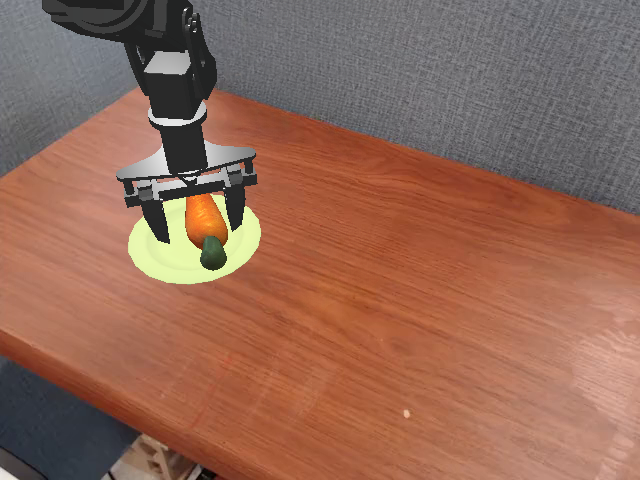

In [24]:
images_for_shadowing = data["image"]
images_for_shadowing[-1]

In [5]:
images_last_action = [Data[i]["arr_0"].item()["image"][-1] for i in range(len(Data))]

len(images_last_action)


75

In [29]:
images_last_action

[<PIL.Image.Image image mode=RGB size=640x480>,
 <PIL.Image.Image image mode=RGB size=640x480>,
 <PIL.Image.Image image mode=RGB size=640x480>,
 <PIL.Image.Image image mode=RGB size=640x480>,
 <PIL.Image.Image image mode=RGB size=640x480>,
 <PIL.Image.Image image mode=RGB size=640x480>,
 <PIL.Image.Image image mode=RGB size=640x480>,
 <PIL.Image.Image image mode=RGB size=640x480>,
 <PIL.Image.Image image mode=RGB size=640x480>,
 <PIL.Image.Image image mode=RGB size=640x480>,
 <PIL.Image.Image image mode=RGB size=640x480>,
 <PIL.Image.Image image mode=RGB size=640x480>,
 <PIL.Image.Image image mode=RGB size=640x480>,
 <PIL.Image.Image image mode=RGB size=640x480>,
 <PIL.Image.Image image mode=RGB size=640x480>,
 <PIL.Image.Image image mode=RGB size=640x480>,
 <PIL.Image.Image image mode=RGB size=640x480>,
 <PIL.Image.Image image mode=RGB size=640x480>,
 <PIL.Image.Image image mode=RGB size=640x480>,
 <PIL.Image.Image image mode=RGB size=640x480>,
 <PIL.Image.Image image mode=RGB size=64

In [6]:
images_first_action = [Data[i]["arr_0"].item()["image"][0] for i in range(len(Data))] #Для проверки recall - у нас есть 58 правильных ответов, что морковь на тарелке, теперь узнаем, что он скажет, когда морковь не на тарелке

len(images_first_action)


75

In [ ]:
questions_list = [
    "What object are in the scene?",
    "Where is the carrot relative to the plate?",
    "Is the carrot on the plate?",
    "Is the gripper holding an object?",
    "Is there an object that can be eaten?",
]

messages = [
    {
        "role": "user",
        "content": [
            # {"type": "image"},
            {"type": "image"},
            {"type": "text", "text": "Can you describe this image? Do you see the robot arm gripper and where? Give relative coords"}
        ]
    },
]

answers = pd.DataFrame(columns=questions_list)

for i, image in enumerate(data["image"]):
    # Prepare inputs
    prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(text=prompt, images=[image], return_tensors="pt")
    inputs = inputs.to(DEVICE)

    # Generate outputs
    generated_ids = model.generate(**inputs, max_new_tokens=500)
    generated_texts = processor.batch_decode(
        generated_ids,
        skip_special_tokens=True,
    )
    answers.append(generated_texts[0].split("Assistant: ")[-1])


In [ ]:
import numpy as np

Data = [np.load(f"./RL4VLA/ManiSkill/mp_collect/PutOnPlateInScene25Single-v1/75/data/success_proc_0_numid_{i}_epsid_{i}.npz", allow_pickle=True) for i in range(0, 75)] 

data = Data[0]["arr_0"].item()

# import pandas as pd

# info_df = pd.DataFrame( [ data["info"][i].values() for i in range(len(data["info"])) ] )
# info_df.columns = data["info"][0].keys()
# info_df["action"] = [item for item in data["action"]]
# print(data["action"][12])

# info_df


({'elapsed_steps': array([30], dtype=int32), 'is_src_obj_grasped': array([False]), 'consecutive_grasp': array([False]), 'src_on_target': array([False]), 'gripper_carrot_dist': array([0.16375038], dtype=float32), 'gripper_plate_dist': array([0.1963564], dtype=float32), 'carrot_plate_dist': array([0.08682613], dtype=float32), 'success': array([False])}, <PIL.Image.Image image mode=RGB size=640x480 at 0x700278E864D0>)
30


30


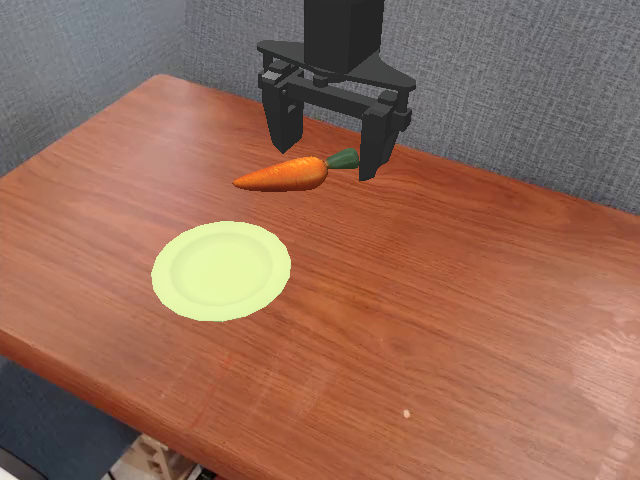

In [131]:
file = (Data[1]["arr_0"].item()["info"][0], Data[1]["arr_0"].item()["image"][0])

print(len(Data[0]["arr_0"].item()["info"]))

file[1]

In [3]:
import numpy as np
import os

def load_data_from_npz(path = None, num_of_samples = None):
    '''Parce all episode data files, extract first, mid and end data'''
    if path is None:
        raise ValueError("You're not send path")
    
    npz_files = [f for f in os.listdir(path) if f.find('.npz') != -1]

    if num_of_samples != None:
        npz_files = npz_files[0:num_of_samples]

    files = {}
    
    for file in npz_files:
        file_path = path + "/" + file
        
        with np.load(file_path, allow_pickle=True) as data:
            mid_index = int(len(data["arr_0"].item()["info"])/2)

            file_summary = {
                "first_iter": {"data": data["arr_0"].item()["info"][0], "image": data["arr_0"].item()["image"][0]},
                "mid_iter": {"data": data["arr_0"].item()["info"][mid_index], "image": data["arr_0"].item()["image"][mid_index]},
                "last_iter": {"data": data["arr_0"].item()["info"][-1], "image": data["arr_0"].item()["image"][-1]},
                "first_iter_QA": {},
                "mid_iter_QA": {},
                "last_iter_QA": {},
            }

            files[f"{file}"] = file_summary

    return files

In [ ]:
import pickle

# Your dictionary
carrot_on_plate_files
# Save to file
with open('carrot_on_plate.pkl', 'wb') as f:
    pickle.dump(carrot_on_plate_files, f)

# Load later
with open('data.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [4]:
# spoon_on_table_clothin_files = load_data_from_npz("./RL4VLA/ManiSkill/mp_collect/PutSpoonOnTableClothInScene-v1/75/data")
carrot_on_plate_files = load_data_from_npz("./RL4VLA/ManiSkill/mp_collect/PutOnPlateInScene25Single-v1/75/data", num_of_samples=20)

In [83]:
carrot_on_plate_files["success_proc_0_numid_70_epsid_70.npz"]["last_iter"]["image"]
a = "first_iter"
for i, (k, v) in enumerate(carrot_on_plate_files.items()):
    print(i, v[a]["image"])
print(len(carrot_on_plate_files))

0 <PIL.Image.Image image mode=RGB size=640x480 at 0x7E30A4731BD0>
1 <PIL.Image.Image image mode=RGB size=640x480 at 0x7E30A4732350>
2 <PIL.Image.Image image mode=RGB size=640x480 at 0x7E30A47329D0>
3 <PIL.Image.Image image mode=RGB size=640x480 at 0x7E30A47331D0>
4 <PIL.Image.Image image mode=RGB size=640x480 at 0x7E30A4731ED0>
5 <PIL.Image.Image image mode=RGB size=640x480 at 0x7E30A4732DD0>
6 <PIL.Image.Image image mode=RGB size=640x480 at 0x7E30A4730850>
7 <PIL.Image.Image image mode=RGB size=640x480 at 0x7E30A4732E50>
8 <PIL.Image.Image image mode=RGB size=640x480 at 0x7E30A4733C50>
9 <PIL.Image.Image image mode=RGB size=640x480 at 0x7E30A47319D0>
10 <PIL.Image.Image image mode=RGB size=640x480 at 0x7E30A4731DD0>
11 <PIL.Image.Image image mode=RGB size=640x480 at 0x7E30A47334D0>
12 <PIL.Image.Image image mode=RGB size=640x480 at 0x7E30A4755350>
13 <PIL.Image.Image image mode=RGB size=640x480 at 0x7E30A47330D0>
14 <PIL.Image.Image image mode=RGB size=640x480 at 0x7E30A4755E50>
15 <P

In [ ]:
from tqdm import tqdm

questions_list = [
    "What objects are in the scene?",
    "Where is objects relative to each other?", #"Where is the carrot relative to the plate?",
    "Is the carrot on the plate?",
    "Is the gripper holding an object?",
    # "Is there an object that can be eaten?",
]


# answers = pd.DataFrame(columns=questions_list)


def collect_answers(data, questions_list, model, processor):
    '''Collect answers for the every question in the question_list and group it by filename'''

    data_len = len(data) 

    collecting_data_loop = tqdm(enumerate(data.items()), leave=True)
    
    iters = [
        "first_iter",
        "mid_iter",
        "last_iter"
    ]

    for i, (filename, filename_data) in collecting_data_loop:
        # Prepare inputs

        for question in questions_list:
            
            message = [
                {
                    "role": "user",
                    "content": [
                        {"type": "image"},
                        {"type": "text", "text": question}
                    ]
                },
            ]


            prompt = processor.apply_chat_template(message, add_generation_prompt=True)
            for Iter in iters:
                inputs = processor(text=prompt, images=[filename_data[Iter]["image"]], return_tensors="pt")
                inputs = inputs.to(DEVICE)

                # Generate outputs
                generated_ids = model.generate(**inputs, max_new_tokens=500)
                generated_text = processor.batch_decode(
                    generated_ids,
                    skip_special_tokens=True,
                )

                answer = generated_text[0].split("Assistant: ")[-1]

                filename_data[Iter + "_QA"][question] = answer
                
                
            collecting_data_loop.set_description(f"collecting data from {i+1}/{data_len} file: {filename}")


# collect_answers(carrot_on_plate_files, questions_list, model=model, processor=processor)

0it [00:08, ?it/s]


KeyboardInterrupt: 

Yes, the carrot is on the plate.


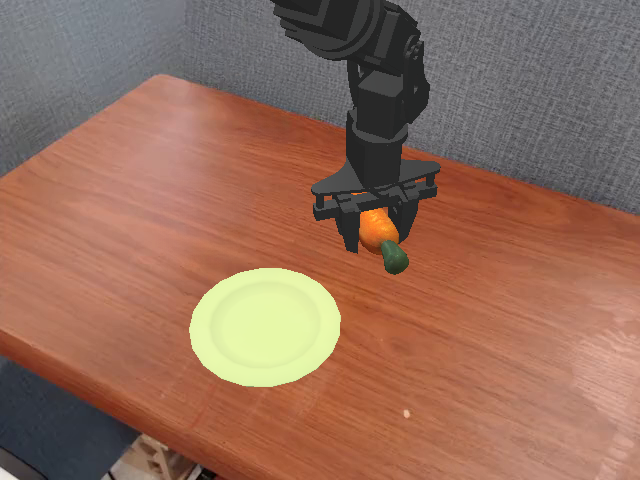

In [6]:
print(carrot_on_plate_files["success_proc_0_numid_70_epsid_70.npz"]["mid_iter_QA"]["Is the carrot on the plate?"])
carrot_on_plate_files["success_proc_0_numid_70_epsid_70.npz"]["mid_iter"]["image"]

['carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate'] ['carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate']


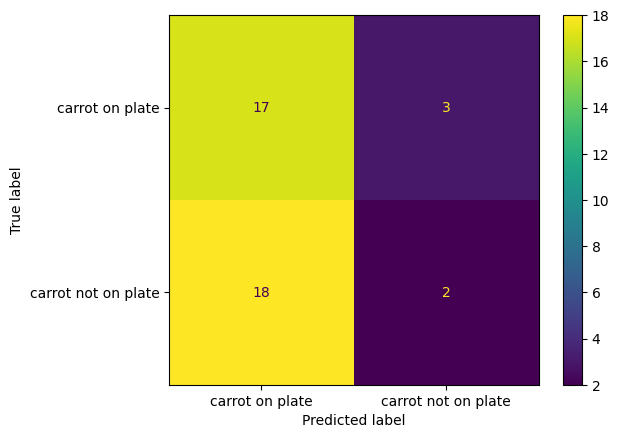

In [5]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

carrot_on_the_plate = ["carrot on plate"]*20
carrot_not_on_the_plate = ["carrot not on plate"]*20
targets = carrot_on_the_plate + carrot_not_on_the_plate

# print(targets)

preds_on_the_plate = []
preds_not_on_the_plate = []


for _, item in carrot_on_plate_files.items():
    preds_on_the_plate.append("carrot on plate" if item["last_iter_QA"]["Is the carrot on the plate?"].lower().find("yes") != -1 else "carrot not on plate")
    preds_not_on_the_plate.append("carrot on plate" if item["first_iter_QA"]["Is the carrot on the plate?"].lower().find("yes") != -1 else "carrot not on plate")
    
    # plt.imshow(item["last_iter"]["image"])
    # plt.axis("off")  
    # plt.show()
print(preds_on_the_plate, preds_not_on_the_plate)
preds = preds_on_the_plate + preds_not_on_the_plate

cm = confusion_matrix(targets, preds, labels=["carrot on plate", "carrot not on plate"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["carrot on plate", "carrot not on plate"])

disp.plot()
# print(preds)
# print(targets)
    

Такие результаты могут быть получены в следствии неправильной формулировки вопроса

In [ ]:
question = ["Is the carrot on the plate? Yes/No."]

collect_answers(carrot_on_plate_files, question, model=model, processor=processor)

collecting data from 20/20 file: success_proc_0_numid_46_epsid_46.npz: : 20it [02:33,  7.69s/it]


['carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate'] ['carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate']


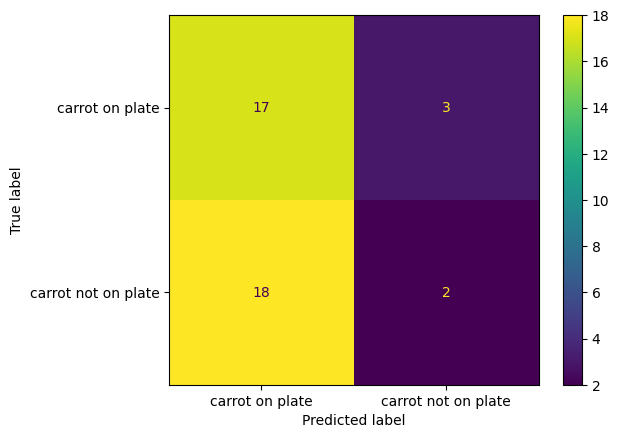

In [7]:
carrot_on_the_plate = ["carrot on plate"]*20
carrot_not_on_the_plate = ["carrot not on plate"]*20
targets = carrot_on_the_plate + carrot_not_on_the_plate

# print(targets)

preds_on_the_plate = []
preds_not_on_the_plate = []


for _, item in carrot_on_plate_files.items():
    preds_on_the_plate.append("carrot on plate" if item["last_iter_QA"]["Is the carrot on the plate? Yes/No."].lower().find("yes") != -1 else "carrot not on plate")
    preds_not_on_the_plate.append("carrot on plate" if item["first_iter_QA"]["Is the carrot on the plate? Yes/No."].lower().find("yes") != -1 else "carrot not on plate")
    
    # plt.imshow(item["last_iter"]["image"])
    # plt.axis("off")  
    # plt.show()
print(preds_on_the_plate, preds_not_on_the_plate)
preds = preds_on_the_plate + preds_not_on_the_plate

cm = confusion_matrix(targets, preds, labels=["carrot on plate", "carrot not on plate"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["carrot on plate", "carrot not on plate"])

disp.plot()

In [ ]:
question = ["Is the orange object (carrot) on the yellow plate in this image? Yes/No."]

collect_answers(carrot_on_plate_files, question, model=model, processor=processor)

collecting data from 20/20 file: success_proc_0_numid_46_epsid_46.npz: : 20it [02:35,  7.80s/it]


['carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate'] ['carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate']


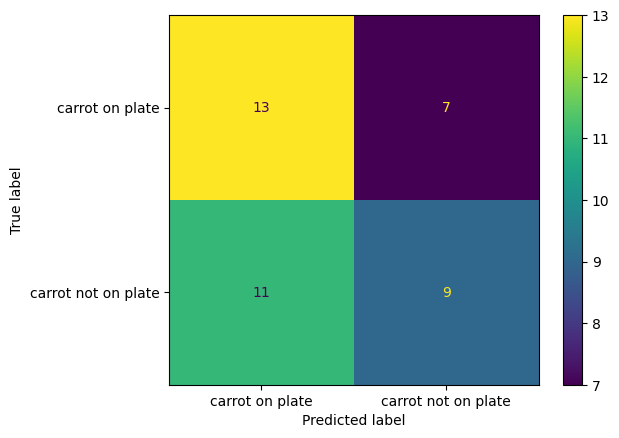

In [8]:
carrot_on_the_plate = ["carrot on plate"]*20
carrot_not_on_the_plate = ["carrot not on plate"]*20
targets = carrot_on_the_plate + carrot_not_on_the_plate

# print(targets)

preds_on_the_plate = []
preds_not_on_the_plate = []


for _, item in carrot_on_plate_files.items():
    preds_on_the_plate.append("carrot on plate" if item["last_iter_QA"]["Is the orange object (carrot) on the yellow plate in this image? Yes/No."].lower().find("yes") != -1 else "carrot not on plate")
    preds_not_on_the_plate.append("carrot on plate" if item["first_iter_QA"]["Is the orange object (carrot) on the yellow plate in this image? Yes/No."].lower().find("yes") != -1 else "carrot not on plate")
    
    # plt.imshow(item["last_iter"]["image"])
    # plt.axis("off")  
    # plt.show()
print(preds_on_the_plate, preds_not_on_the_plate)
preds = preds_on_the_plate + preds_not_on_the_plate

cm = confusion_matrix(targets, preds, labels=["carrot on plate", "carrot not on plate"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["carrot on plate", "carrot not on plate"])

disp.plot()

Есть подозрение, что для VLM намного больше значит цветовое представление объекта, чем общее название

In [16]:
question = ["Is the orange object on the yellow object in this image? Yes/No."]

collect_answers(carrot_on_plate_files, question, model=model, processor=processor)

collecting data from 20/20 file: success_proc_0_numid_46_epsid_46.npz: : 20it [02:34,  7.73s/it]


['carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate'] ['carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate']


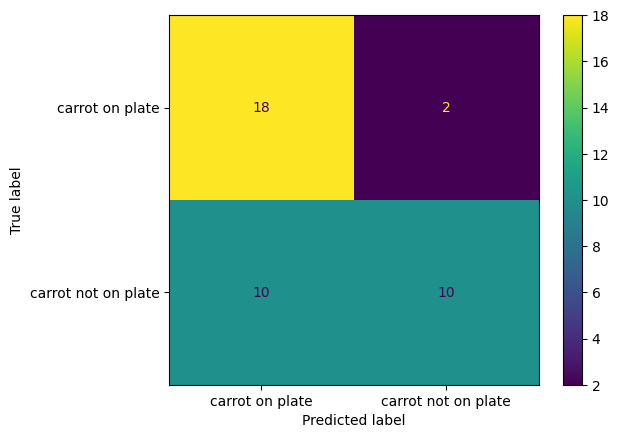

In [6]:
carrot_on_the_plate = ["carrot on plate"]*20
carrot_not_on_the_plate = ["carrot not on plate"]*20
targets = carrot_on_the_plate + carrot_not_on_the_plate

# print(targets)

preds_on_the_plate = []
preds_not_on_the_plate = []


for _, item in carrot_on_plate_files.items():
    preds_on_the_plate.append("carrot on plate" if item["last_iter_QA"]["Is the orange object on the yellow object in this image? Yes/No."].lower().find("yes") != -1 else "carrot not on plate")
    preds_not_on_the_plate.append("carrot on plate" if item["first_iter_QA"]["Is the orange object on the yellow object in this image? Yes/No."].lower().find("yes") != -1 else "carrot not on plate")
    
    # plt.imshow(item["last_iter"]["image"])
    # plt.axis("off")  
    # plt.show()
print(preds_on_the_plate, preds_not_on_the_plate)
preds = preds_on_the_plate + preds_not_on_the_plate

cm = confusion_matrix(targets, preds, labels=["carrot on plate", "carrot not on plate"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["carrot on plate", "carrot not on plate"])

disp.plot()

['Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding'] ['Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding']


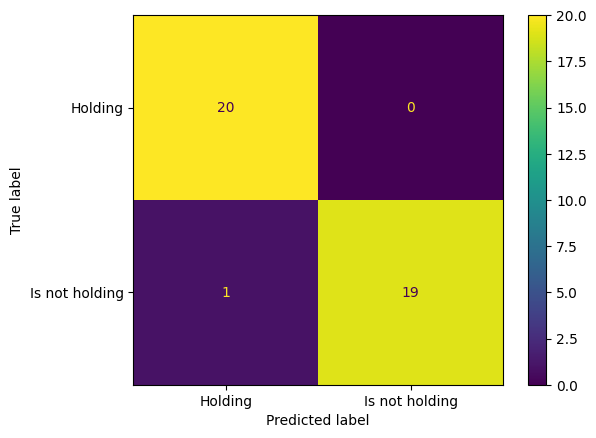

In [10]:
Hold_carrot = ["Holding"]*20
Is_not_hold_carrot = ["Is not holding"]*20
targets = Hold_carrot + Is_not_hold_carrot

# print(targets)

preds_on_the_plate = []
preds_not_on_the_plate = []


for _, item in carrot_on_plate_files.items():
    preds_on_the_plate.append("Holding" if item["last_iter_QA"]["Is the gripper holding an object?"].lower().find("yes") != -1 else "Is not holding")
    preds_not_on_the_plate.append("Holding" if item["first_iter_QA"]["Is the gripper holding an object?"].lower().find("yes") != -1 else "Is not holding")
    
    # plt.imshow(item["last_iter"]["image"])
    # plt.axis("off")  
    # plt.show()
print(preds_on_the_plate, preds_not_on_the_plate)
preds = preds_on_the_plate + preds_not_on_the_plate

cm = confusion_matrix(targets, preds, labels=["Holding", "Is not holding"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Holding", "Is not holding"])

disp.plot()

In [3]:
import pickle

# # Your dictionary
# carrot_on_plate_files
# # Save to file
# with open('carrot_on_plate.pkl', 'wb') as f:
#     pickle.dump(carrot_on_plate_files, f)

# Load later
with open('carrot_on_plate.pkl', 'rb') as f:
    carrot_on_plate_files = pickle.load(f)

In [4]:
if loaded_dict["success_proc_0_numid_70_epsid_70.npz"]['last_iter']['data']["src_on_target"].astype(bool) == 0:
    print("NO")
else:
    print("YES")

NameError: name 'loaded_dict' is not defined

In [53]:
type(loaded_dict["success_proc_0_numid_70_epsid_70.npz"]['first_iter']['image'])

PIL.Image.Image

Попробуем улучшить понимание модели, что именно объект "морковь" лежит или не лежит именно на объекте "тарелка"

In [24]:
!pip install peft accelerate transformers datasets wandb

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [6]:
import wandb
from datasets import load_dataset

import torch
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from transformers import AutoProcessor, BitsAndBytesConfig, Idefics3ForConditionalGeneration

In [8]:

# if model:
#     del model
#     print("delete model")
# if processor:
#     del processor  # if exists
#     print("delete processor")
import gc, torch
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


model_id = "HuggingFaceTB/SmolVLM-256M-Instruct"
processor = AutoProcessor.from_pretrained(model_id)

lora_config = LoraConfig(
    r=8,             
    lora_alpha=8,    
    target_modules=['down_proj','o_proj','k_proj','q_proj','gate_proj','up_proj','v_proj'],  
    lora_dropout=0.1,
    bias="none",
    use_dora = True,
    # task_type="SEQ_2_SEQ_LM"
    init_lora_weights="gaussian",
)
lora_config.inference_mode = False

model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    _attn_implementation="eager", 
).to(DEVICE)

model.add_adapter(lora_config)
model.enable_adapters()
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


/home/anton/miniconda3/lib/python3.13/site-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/home/anton/miniconda3/lib/python3.13/site-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


trainable params: 3,067,776 || all params: 259,552,704 || trainable%: 1.1819


In [24]:
model.unload()

Idefics3ForConditionalGeneration(
  (model): Idefics3Model(
    (vision_model): Idefics3VisionTransformer(
      (embeddings): Idefics3VisionEmbeddings(
        (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
        (position_embedding): Embedding(1024, 768)
      )
      (encoder): Idefics3Encoder(
        (layers): ModuleList(
          (0-11): 12 x Idefics3EncoderLayer(
            (self_attn): Idefics3VisionAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (mlp): Idefics3VisionMLP(
              (activation_fn): PytorchGELUTanh()
              (fc1): Linear(in_features=7

Соберём json датасет для дообучения нашей модели 

In [ ]:


def build_jsonl_from_first_and_last(data, questions, answer_key, output_file=None):
    os.makedirs("./images", exist_ok=True)

    assert output_file != None, "Set the output filename!"
    counter = 0

    with open(output_file, "w", encoding="utf-8") as f:
        for question in questions:
            for _, item in data.items():

                img_first = f"./images/first_iter_{question}_{counter}.png"
                item["first_iter"]["image"].save(img_first)
                img_first = os.path.relpath(img_first)

                img_last = f"./images/last_iter_{question}_{counter}.png"
                item["last_iter"]["image"].save(img_last)
                img_last = os.path.relpath(img_last)

                sample = {
                    "image": img_first,  
                    "question": question, #########################################################################Сделать просто рандомные вопросы из списка, чтобы картинки не могли повторяться
                    "answer": "yes" if item["first_iter"]["data"][answer_key] else "no"
                }
                f.write(json.dumps(sample, ensure_ascii=False) + "\n")
                sample = {
                    "image": img_last,  
                    "question": question,
                    "answer": "yes" if item["last_iter"]["data"][answer_key] else "no"
                }
                f.write(json.dumps(sample, ensure_ascii=False) + "\n")
                counter+=1

            #Добавить для negative samples
    
    print(f"Saved {counter*2} samples to {output_file}")
    return output_file

questions = [
    "Is the carrot on the plate?",
    "Is the carrot placed on the plate?",
    "Has the carrot been put on the plate?",
]
qa_dataset_file = build_jsonl_from_first_and_last(carrot_on_plate_files, questions, "src_on_target", "carrot_on_the_plate_dataset.jsonl")




Saved 120 samples to carrot_on_the_plate_dataset.jsonl


In [4]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Load as dataframe
df = pd.read_json("carrot_on_the_plate_dataset.jsonl", lines=True)

train_df, test_df = train_test_split(
    df, test_size=0.3, stratify=df["answer"], random_state=42
)

train_df.to_json("train.jsonl", orient="records", lines=True)
test_df.to_json("test.jsonl", orient="records", lines=True)

dataset = load_dataset(
    "json",
    data_files={"train": "train.jsonl", "test": "test.jsonl"}
)



Generating train split: 84 examples [00:00, 11666.66 examples/s]
Generating test split: 36 examples [00:00, 11720.48 examples/s]


In [9]:
image_token_id = processor.tokenizer.additional_special_tokens_ids[
            processor.tokenizer.additional_special_tokens.index("<image>")]

def collate_fn(examples):
  texts = []
  images = []
  for example in examples:
      image = Image.open(example["image"]).convert("RGB")
      question = example["question"]
      answer = example["answer"]
    #   print(question, answer)
      messages = [
          {
              "role": "user",
              "content": [
                #   {"type": "text", "text": "Answer briefly."},
                  {"type": "image"},
                  {"type": "text", "text": question}
              ]
          },
          {
              "role": "assistant",
              "content": [
                  {"type": "text", "text": answer}
              ]
          }
      ]
      text = processor.apply_chat_template(messages, add_generation_prompt=False)
      texts.append(text.strip())
      images.append([image])
    #   break ####################################################################

  batch = processor(text=texts, images=images, return_tensors="pt", padding=True)
  labels = batch["input_ids"].clone()
  labels[labels == processor.tokenizer.pad_token_id] = -100
  labels[labels == image_token_id] = -100
  batch["labels"] = labels

  return batch

# batch = collate_fn(dataset["train"])

In [5]:
batch

{'pixel_values': tensor([[[[[-0.0118,  0.0039,  0.0275,  ..., -0.0745, -0.0745, -0.0667],
           [-0.0118,  0.0039,  0.0275,  ..., -0.0745, -0.0745, -0.0667],
           [-0.0039,  0.0039,  0.0275,  ..., -0.0745, -0.0745, -0.0667],
           ...,
           [-0.2392, -0.2392, -0.2392,  ...,  0.5216,  0.5216,  0.5216],
           [-0.2471, -0.2471, -0.2471,  ...,  0.5216,  0.5216,  0.5216],
           [-0.2549, -0.2549, -0.2627,  ...,  0.5216,  0.5216,  0.5216]],

          [[ 0.0118,  0.0275,  0.0510,  ..., -0.0510, -0.0510, -0.0431],
           [ 0.0118,  0.0275,  0.0510,  ..., -0.0510, -0.0510, -0.0431],
           [ 0.0196,  0.0275,  0.0510,  ..., -0.0510, -0.0510, -0.0431],
           ...,
           [-0.2627, -0.2627, -0.2549,  ...,  0.1294,  0.1294,  0.1294],
           [-0.2627, -0.2627, -0.2627,  ...,  0.1294,  0.1294,  0.1294],
           [-0.2627, -0.2627, -0.2627,  ...,  0.1294,  0.1294,  0.1294]],

          [[ 0.0667,  0.0824,  0.1059,  ...,  0.0039,  0.0039,  0.0118]

In [10]:
from transformers import TrainingArguments, Trainer

In [11]:
model_name = model_id.split("/")[-1]

training_args = TrainingArguments(
    num_train_epochs=1,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=1,
    warmup_steps=50,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_steps=25,
    save_strategy="steps",
    save_steps=250,
    save_total_limit=1,
    optim="paged_adamw_8bit", # for 8-bit, keep this, else adamw_hf
    bf16=True, # underlying precision for 8bit
    output_dir=f"./{model_name}-carrots-and-plates",
    hub_model_id=f"{model_name}-carrots-and-plates",
    report_to="tensorboard",
    remove_unused_columns=False,
    gradient_checkpointing=True
)

In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=dataset["train"],
)

No label_names provided for model class `PeftModel`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [13]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 624.00 MiB. GPU 0 has a total capacity of 5.93 GiB of which 345.69 MiB is free. Including non-PyTorch memory, this process has 5.02 GiB memory in use. Of the allocated memory 3.77 GiB is allocated by PyTorch, and 1.16 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [6]:
from transformers import AutoProcessor, AutoModelForVision2Seq
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# fine-tuned checkpoint (weights + config.json)
fit_model_id = "./SmolVLM-256M-Instruct-vqav2/checkpoint-42"

# load processor from the *original* pretrained model
base_model_id = "HuggingFaceTB/SmolVLM-256M-Instruct"
processor = AutoProcessor.from_pretrained(base_model_id)

# load the fine-tuned weights
model = AutoModelForVision2Seq.from_pretrained(
    fit_model_id,
    torch_dtype=torch.float16,
    _attn_implementation="eager"
).to(DEVICE)


In [14]:
question = ["Is the carrot on the plate? Yes/No."]

collect_answers(carrot_on_plate_files, question, model=model, processor=processor)

collecting data from 20/20 file: success_proc_0_numid_46_epsid_46.npz: : 20it [02:36,  7.83s/it]


['carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate'] ['carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate']


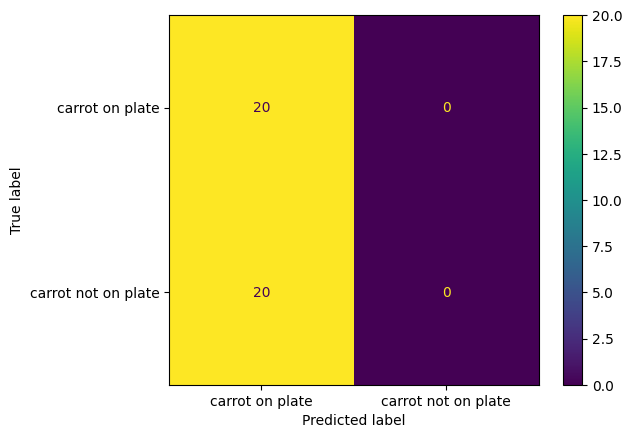

In [15]:
carrot_on_the_plate = ["carrot on plate"]*20
carrot_not_on_the_plate = ["carrot not on plate"]*20
targets = carrot_on_the_plate + carrot_not_on_the_plate

# print(targets)

preds_on_the_plate = []
preds_not_on_the_plate = []


for _, item in carrot_on_plate_files.items():
    preds_on_the_plate.append("carrot on plate" if item["last_iter_QA"]["Is the carrot on the plate? Yes/No."].lower().find("yes") != -1 else "carrot not on plate")
    preds_not_on_the_plate.append("carrot on plate" if item["first_iter_QA"]["Is the carrot on the plate? Yes/No."].lower().find("yes") != -1 else "carrot not on plate")
    
    # plt.imshow(item["last_iter"]["image"])
    # plt.axis("off")  
    # plt.show()
print(preds_on_the_plate, preds_not_on_the_plate)
preds = preds_on_the_plate + preds_not_on_the_plate

cm = confusion_matrix(targets, preds, labels=["carrot on plate", "carrot not on plate"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["carrot on plate", "carrot not on plate"])

disp.plot()

После этого проверить способность дообученной модели ещё на "Кубики сейчас друг на друге?" и "Зелёный объект сейчас на жёлтом объекте?"

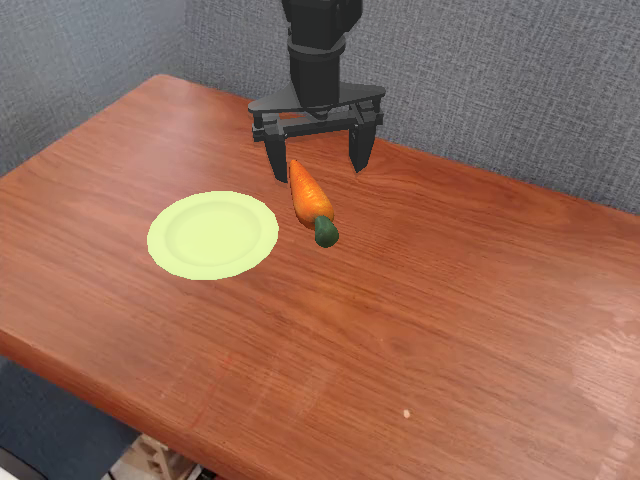

In [47]:
from PIL import Image

# Load images and convert to RGBA
img1 = images_for_shadowing[10].convert("RGBA")
img2 = images_for_shadowing[9].convert("RGBA")
img3 = images_for_shadowing[8].convert("RGBA")

# Blend gradually
blend1 = Image.blend(img1, img2, alpha=0.7)  # second image faint
final = Image.blend(blend1, img3, alpha=0.5) # third image even fainter

final


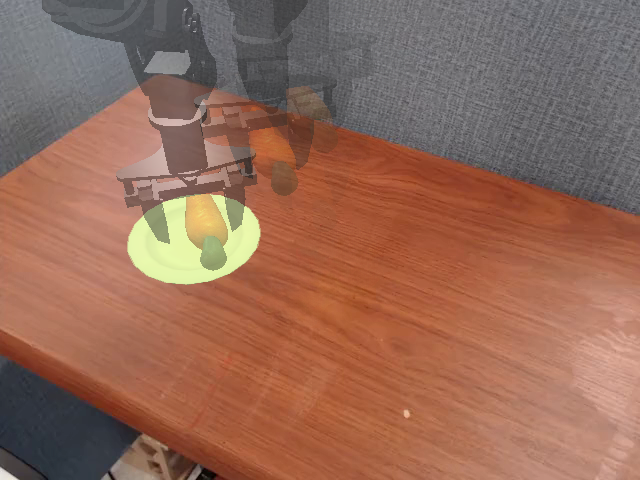

In [86]:
from PIL import Image
import numpy as np

def create_trail(frames, alphas=None):
    """
    Create a motion trail effect by blending multiple PIL RGB frames.
    
    frames: list of PIL.Image.Image objects (all same size, RGB).
    alphas: list of weights (same length as frames) — if None, use fading weights.
    
    Returns: PIL.Image.Image with trail effect.
    """
    n = len(frames)
    if alphas is None:
        # Decreasing weights (strongest for most recent frame)
        alphas = np.linspace(0.8, 0.1, n)  
    alphas = np.array(alphas) / np.sum(alphas)  # normalize
    
    # Convert frames to numpy arrays
    arrays = [np.asarray(f).astype(np.float32) for f in frames]
    
    # Weighted sum
    result = np.zeros_like(arrays[0])
    for arr, w in zip(arrays, alphas):
        result += arr * w
    
    result = np.clip(result, 0, 255).astype(np.uint8)
    return Image.fromarray(result)

ifs = images_for_shadowing[::-4]
trail_img = create_trail(ifs[0:4])
trail_img


In [ ]:
# Create input messages
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "image"},
            {"type": "text", "text": "Can you describe the carrot path?"}
        ]
    },
]

# Prepare inputs
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[images_for_shadowing[0], images_for_shadowing[-1]], return_tensors="pt")
inputs = inputs.to(DEVICE)

# Generate outputs
generated_ids = model.generate(**inputs, max_new_tokens=500)
generated_texts = processor.batch_decode(
    generated_ids,
    skip_special_tokens=True,
)

print(generated_texts[0])

User:







Can you describe the carrot path?
Assistant: The carrot is on the carrot path.


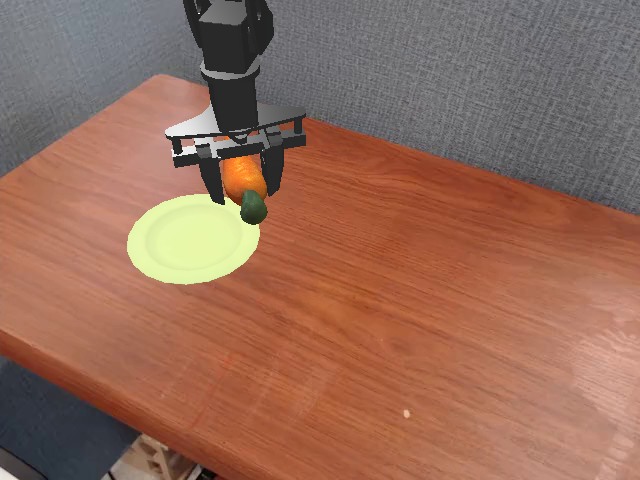

In [95]:
images_for_shadowing[-4]

In [ ]:
# Create input messages
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "image"},
            {"type": "text", "text": "Can you describe the carrot path?"}
        ]
    },
]

# Prepare inputs
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[images_for_shadowing[0], images_for_shadowing[-1]], return_tensors="pt")
inputs = inputs.to(DEVICE)

# Generate outputs
generated_ids = model.generate(**inputs, max_new_tokens=500)
generated_texts = processor.batch_decode(
    generated_ids,
    skip_special_tokens=True,
)

print(generated_texts[0])